In [1]:
from torchvision import models
from ptflops import get_model_complexity_info


resnet = models.resnet101(pretrained=True)
macs, params = get_model_complexity_info(resnet, (3, 224, 224), as_strings=True, print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       7.85 GMac
Number of parameters:           44.55 M 


In [9]:
with open('./imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

In [10]:
from torchvision import transforms
preprocess = transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize(
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]
)])

In [11]:
from PIL import Image
img1 = Image.open("./images/cat.jpg")
img2 = Image.open("./images/rkt.jfif")
img3 = Image.open("./images/coaster.jpeg")
img4 = Image.open("./images/car.jpeg")
img5 = Image.open("./images/ship.jpg")

In [12]:
img1_t = preprocess(img1)
img2_t = preprocess(img2)
img3_t = preprocess(img3)
img4_t = preprocess(img4)
img5_t = preprocess(img5)

In [13]:
import torch
batch1_t = torch.unsqueeze(img1_t, 0)
batch2_t = torch.unsqueeze(img2_t, 0)
batch3_t = torch.unsqueeze(img3_t, 0)
batch4_t = torch.unsqueeze(img4_t, 0)
batch5_t = torch.unsqueeze(img5_t, 0)

In [14]:
out1 = resnet(batch1_t)
out2 = resnet(batch2_t)
out3 = resnet(batch3_t)
out4 = resnet(batch4_t)
out5 = resnet(batch5_t)

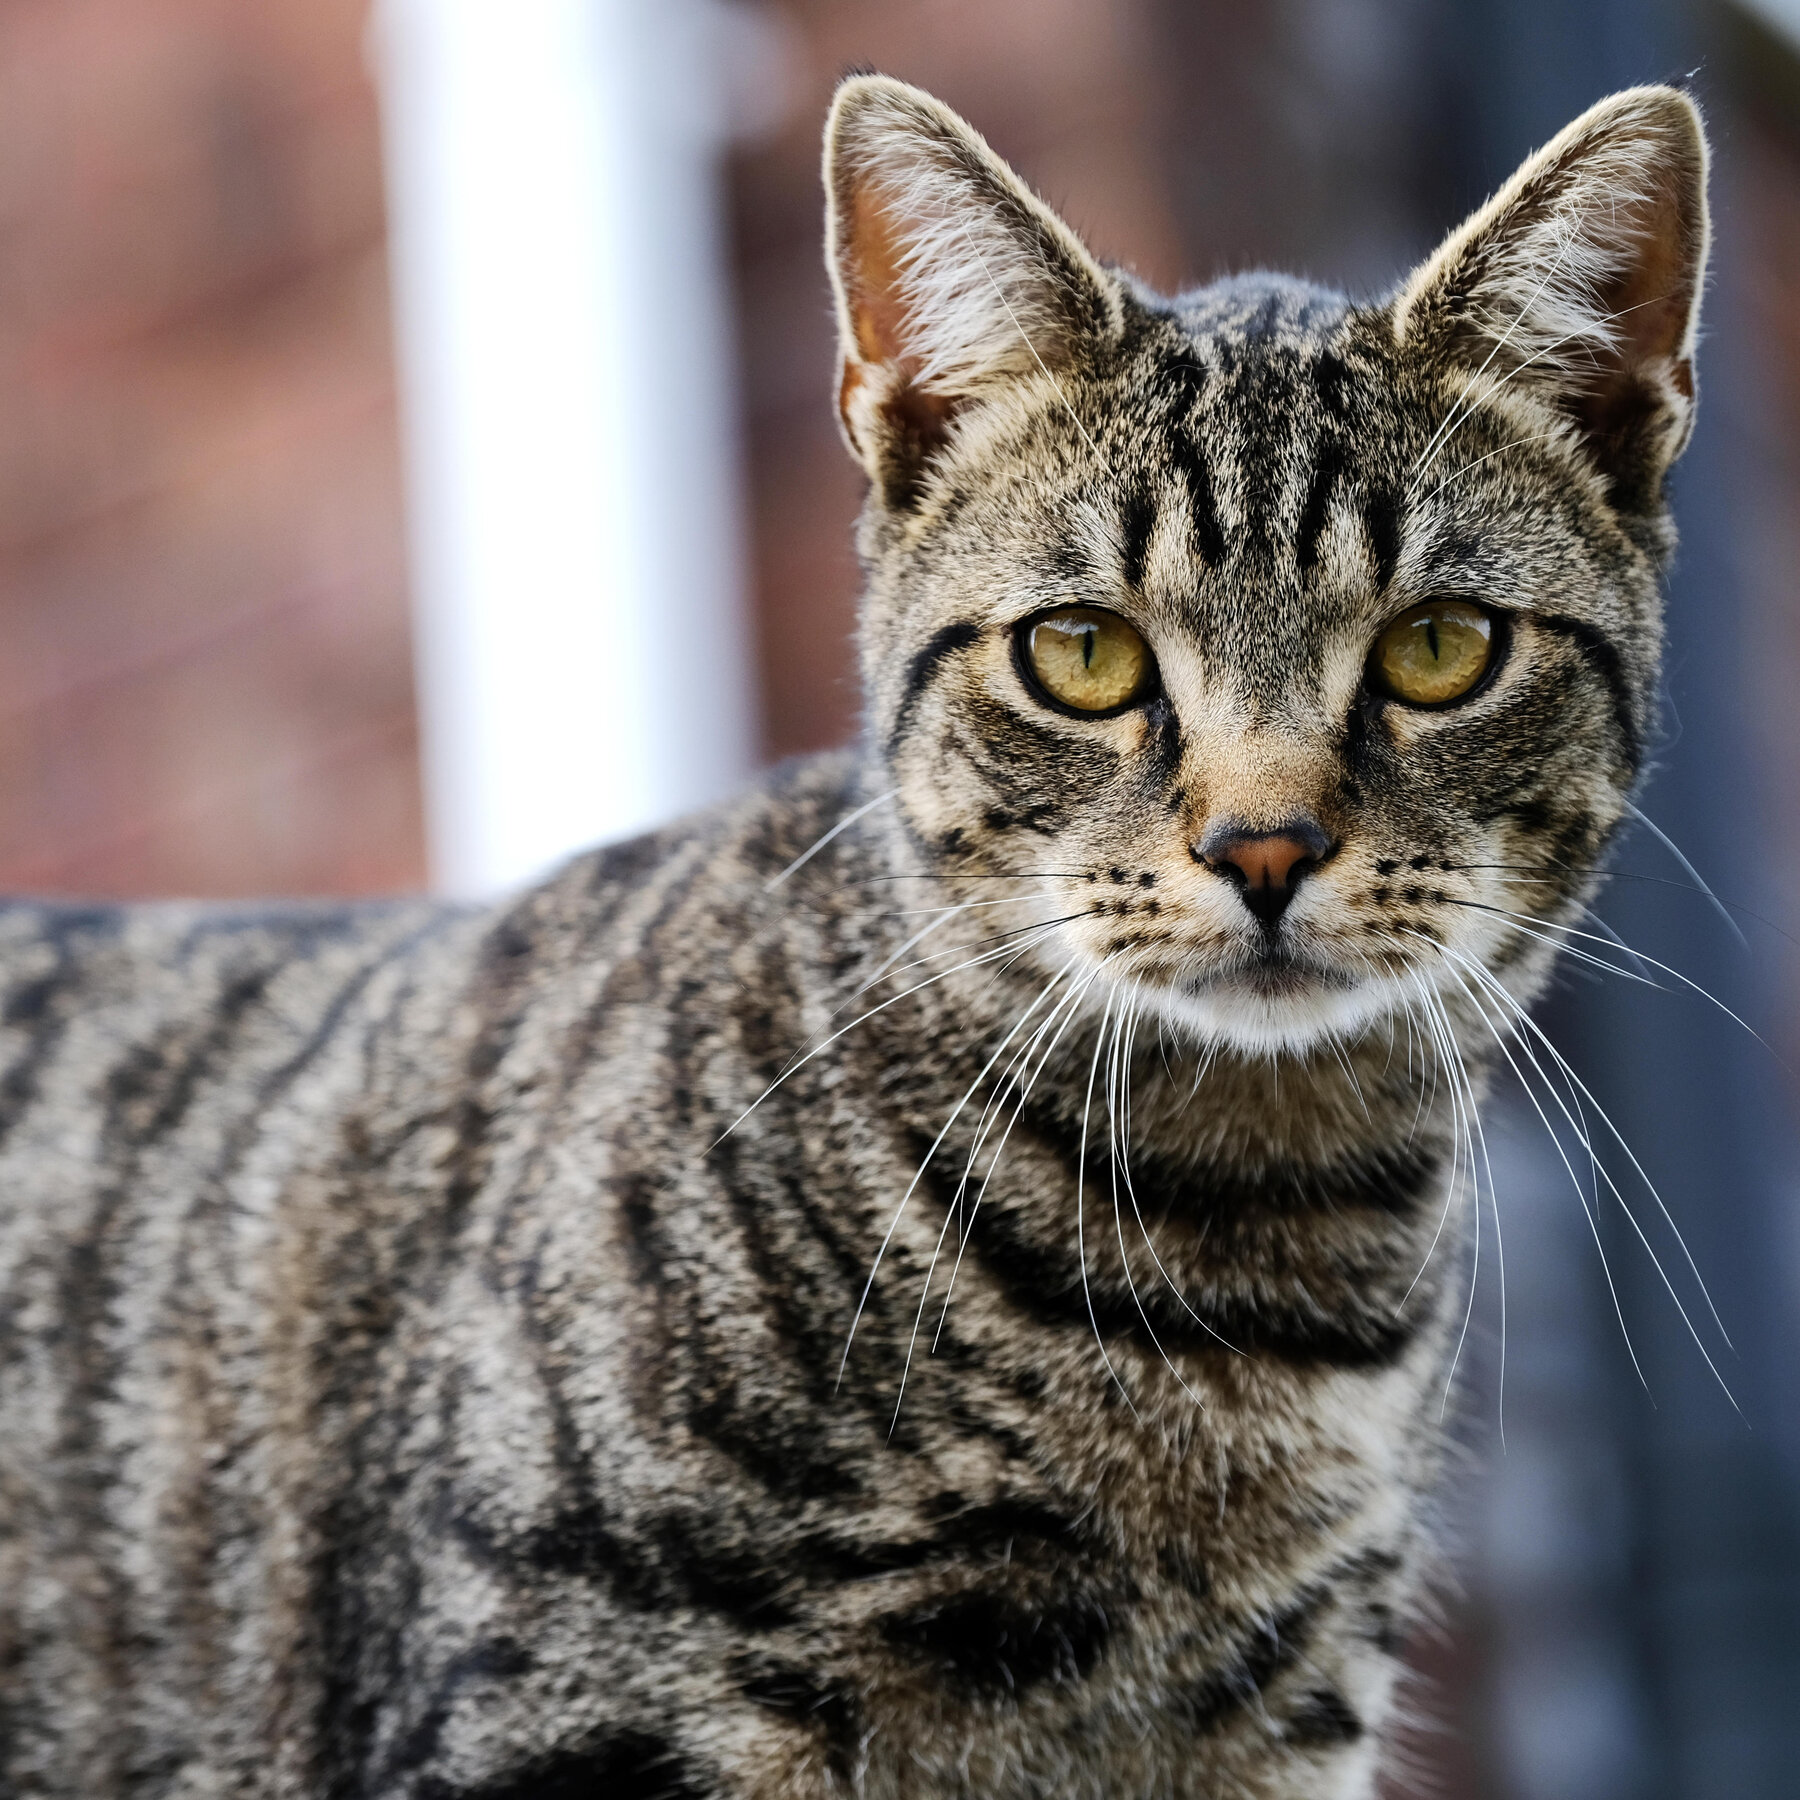

In [15]:
img1

In [16]:

_, index = torch.max(out1, 1)
percentage = torch.nn.functional.softmax(out1, dim=1)[0] * 100
_, indices = torch.sort(out1, descending=True)
print([(labels[idx], percentage[idx].item()) for idx in indices[0][:5]])
#cat
print("\n")
_, index = torch.max(out2, 1)
percentage = torch.nn.functional.softmax(out2, dim=1)[0] * 100
_, indices = torch.sort(out2, descending=True)
print([(labels[idx], percentage[idx].item()) for idx in indices[0][:5]])
#rocket
print("\n")

_, index = torch.max(out3, 1)
percentage = torch.nn.functional.softmax(out3, dim=1)[0] * 100
_, indices = torch.sort(out3, descending=True)
print([(labels[idx], percentage[idx].item()) for idx in indices[0][:5]])
#roller coaster
print("\n")

_, index = torch.max(out4, 1)
percentage = torch.nn.functional.softmax(out4, dim=1)[0] * 100
_, indices = torch.sort(out4, descending=True)
print([(labels[idx], percentage[idx].item()) for idx in indices[0][:5]])
#car
print("\n")

_, index = torch.max(out5, 1)
percentage = torch.nn.functional.softmax(out5, dim=1)[0] * 100
_, indices = torch.sort(out5, descending=True)
print([(labels[idx], percentage[idx].item()) for idx in indices[0][:5]])
#battleship



[('tiger cat', 79.66744232177734), ('tabby, tabby cat', 19.672622680664062), ('Egyptian cat', 0.5914100408554077), ('tiger, Panthera tigris', 0.023916659876704216), ('lynx, catamount', 0.007003657054156065)]


[('space shuttle', 99.93167114257812), ('missile', 0.036954112350940704), ('projectile, missile', 0.03135554865002632), ('warplane, military plane', 1.5263885870808735e-05), ('mashed potato', 5.9588342082861345e-06)]


[('steel arch bridge', 36.37282943725586), ('pier', 27.173280715942383), ('suspension bridge', 10.464879989624023), ('fireboat', 6.59556770324707), ('crane', 3.4209132194519043)]


[('sports car, sport car', 98.20326232910156), ('convertible', 0.7206903100013733), ('car wheel', 0.6490448713302612), ('racer, race car, racing car', 0.3668653070926666), ('crash helmet', 0.022363141179084778)]


[('space shuttle', 42.99848175048828), ('aircraft carrier, carrier, flattop, attack aircraft carrier', 27.45186996459961), ('missile', 14.654141426086426), ('projectile, missil

In [ ]:
#PART 2

In [5]:
#copy pasted from textbook
import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [13]:
netG = ResNetGenerator()
macs, params = get_model_complexity_info(netG, (3, 224, 224), as_strings=True, print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       43.55 GMac
Number of parameters:           11.38 M 


In [12]:
model_path = './data/p1ch2/horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [49]:
netG.eval()
from PIL import Image
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize(256),
transforms.ToTensor()])

In [58]:
from PIL import Image
img1 = Image.open("./images/horse1.jpg")
img2 = Image.open("./images/horse2.jpg")
img3 = Image.open("./images/horse3.jpg")
img4 = Image.open("./images/horse4.jpg")
img5 = Image.open("./images/horse5.jpg")

img1_t = preprocess(img1)
img2_t = preprocess(img2)
img3_t = preprocess(img3)
img4_t = preprocess(img4)
img5_t = preprocess(img5)
import torch
batch1_t = torch.unsqueeze(img1_t, 0)
batch2_t = torch.unsqueeze(img2_t, 0)
batch3_t = torch.unsqueeze(img3_t, 0)
batch4_t = torch.unsqueeze(img4_t, 0)
batch5_t = torch.unsqueeze(img5_t, 0)

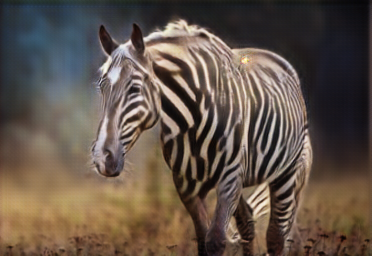

In [59]:
batch_out = netG(batch1_t)

out1_t = (batch_out.data.squeeze() + 1.0) / 2.0
out1_img = transforms.ToPILImage()(out1_t)
out1_img


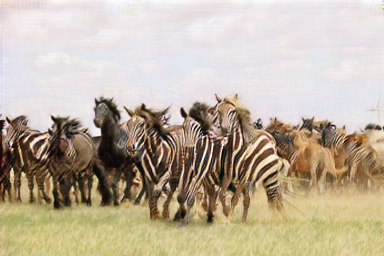

In [60]:
batch_out = netG(batch2_t)

out2_t = (batch_out.data.squeeze() + 1.0) / 2.0
out2_img = transforms.ToPILImage()(out2_t)
out2_img


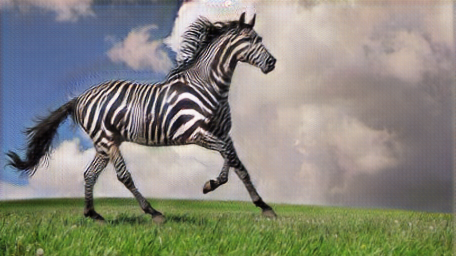

In [61]:
batch_out = netG(batch3_t)

out3_t = (batch_out.data.squeeze() + 1.0) / 2.0
out3_img = transforms.ToPILImage()(out3_t)
out3_img


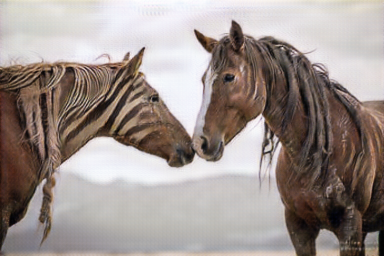

In [62]:
batch_out = netG(batch4_t)

out4_t = (batch_out.data.squeeze() + 1.0) / 2.0
out4_img = transforms.ToPILImage()(out4_t)
out4_img


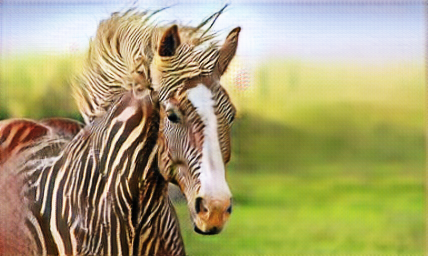

In [63]:
batch_out = netG(batch5_t)

out5_t = (batch_out.data.squeeze() + 1.0) / 2.0
out5_img = transforms.ToPILImage()(out5_t)
out5_img


In [2]:
#PART 4

import torch
from ptflops import get_model_complexity_info

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True, print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))
model.eval()

Computational complexity:       0.32 GMac
Number of parameters:           3.5 M   


Using cache found in C:\Users\dstok/.cache\torch\hub\pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [5]:
import torchvision
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [19]:
from PIL import Image
img1 = Image.open("./images/cat.jpg")
img2 = Image.open("./images/rkt.jfif")
img3 = Image.open("./images/coaster.jpeg")
img4 = Image.open("./images/car.jpeg")
img5 = Image.open("./images/ship.jpg")

img1_t = preprocess(img1)
img2_t = preprocess(img2)
img3_t = preprocess(img3)
img4_t = preprocess(img4)
img5_t = preprocess(img5)

import torch
batch1_t = torch.unsqueeze(img1_t, 0)
batch2_t = torch.unsqueeze(img2_t, 0)
batch3_t = torch.unsqueeze(img3_t, 0)
batch4_t = torch.unsqueeze(img4_t, 0)
batch5_t = torch.unsqueeze(img5_t, 0)

In [20]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [21]:
with torch.no_grad():
    output = model(batch1_t)
    
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

tiger cat 0.6524982452392578
tabby, tabby cat 0.3171881139278412
Egyptian cat 0.023562101647257805
tiger, Panthera tigris 0.00249707093462348
lynx, catamount 0.0022880826145410538


In [22]:
with torch.no_grad():
    output = model(batch2_t)
    
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

space shuttle 0.9988172650337219
missile 0.0006802126881666481
projectile, missile 0.0004809879173990339
mashed potato 2.014709752984345e-05
steam locomotive 4.26946627385405e-07


In [23]:
with torch.no_grad():
    output = model(batch3_t)
    
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

steel arch bridge 0.9232251048088074
coil, spiral, volute, whorl, helix 0.010669747367501259
suspension bridge 0.010072924196720123
pier 0.005228039808571339
harp 0.004433175083249807


In [24]:
with torch.no_grad():
    output = model(batch4_t)
    
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

sports car, sport car 0.9702891707420349
car wheel 0.017880164086818695
racer, race car, racing car 0.004553707782179117
cab, hack, taxi, taxicab 0.0022443532943725586
grille, radiator grille 0.0020572750363498926


In [25]:
with torch.no_grad():
    output = model(batch5_t)
    
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

missile 0.4829239845275879
projectile, missile 0.22751489281654358
space shuttle 0.16545383632183075
amphibian, amphibious vehicle 0.02598855458199978
aircraft carrier, carrier, flattop, attack aircraft carrier 0.022052939981222153
